In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the pbmc3k dataset
adata = sc.datasets.pbmc3k()

print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


In [3]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata)


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'


In [4]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Store the raw data
adata.raw = adata



In [5]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


1872


In [6]:
adata

View of AnnData object with n_obs × n_vars = 2700 × 1872
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Dimension Reduction

###  GLM-PCA

In [ ]:
import rpy2.robjects as robjects

# # Initialize R instance
# r = robjects.r

# # Install BiocManager directly using R
# r('install.packages("BiocManager", repos="http://cran.us.r-project.org")')
# r('BiocManager::install()')

# # Now, try installing glmpca package
# r('BiocManager::install("glmpca")')


In [11]:
# Import rpy2's package module
import rpy2.robjects.packages as rpackages

# Import rpy2's utility module
import rpy2.robjects as ro

# R package names
packnames = ('glmpca', 'BiocManager')

# R package utility function
utils = rpackages.importr('utils')

# Select a mirror for R packages
utils.chooseCRANmirror(ind=1)  # select the first mirror in the list

# R package manager
BiocManager = rpackages.importr('BiocManager')

# Install packages
for pkg in packnames:
    if not rpackages.isinstalled(pkg):
        BiocManager.install(pkg)


In [12]:
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter

# Activate the pandas2ri interface
pandas2ri.activate()

# Assume 'adata' is your AnnData object from the previous steps
# Convert the AnnData to a DataFrame for the count data
with localconverter(robjects.default_converter + pandas2ri.converter):
    count_data = robjects.conversion.py2rpy(adata.to_df())

# Load the glmpca library in R
robjects.r('library(glmpca)')

# Perform GLM-PCA with the count data
# The number of dimensions L can be adjusted as needed
robjects.r.assign('count_data', count_data)
robjects.r('glmpca_res <- glmpca(count_data, L=10)')

# Retrieve the low-dimensional representation
glmpca_res = robjects.r('glmpca_res$loadings')

# Convert the results back to a pandas DataFrame
with localconverter(robjects.default_converter + pandas2ri.converter):
    glmpca_loadings = robjects.conversion.rpy2py(glmpca_res)

# Deactivate the pandas2ri interface
pandas2ri.deactivate()

# glmpca_loadings now contains the principal components for each cell
print(glmpca_loadings)


                      dim1      dim2      dim3      dim4      dim5      dim6  \
AAACATACAACCAC-1 -0.027410  0.003848 -0.002058 -0.016415  0.025447  0.047349   
AAACATTGAGCTAC-1 -0.006770 -0.029601 -0.002498 -0.005162  0.005089  0.012483   
AAACATTGATCAGC-1 -0.013530  0.012462 -0.023540 -0.002915  0.011687  0.024180   
AAACCGTGCTTCCG-1 -0.006725 -0.002148  0.020812  0.011944  0.032797  0.007501   
AAACCGTGTATGCG-1 -0.021112  0.022207  0.047877 -0.033468 -0.032299 -0.013092   
...                    ...       ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1 -0.001138 -0.002600  0.010756  0.021413 -0.011105 -0.013359   
TTTCTACTGAGGCA-1 -0.009904 -0.025713 -0.022221 -0.010590  0.001921  0.015846   
TTTCTACTTCCTCG-1 -0.025380 -0.056362  0.007709  0.007789 -0.002315  0.027232   
TTTGCATGAGAGGC-1 -0.011541 -0.031506  0.014806 -0.026766 -0.012422 -0.019034   
TTTGCATGCCTCAC-1 -0.022303  0.006737 -0.012785  0.018227 -0.010857  0.004537   

                      dim7      dim8   

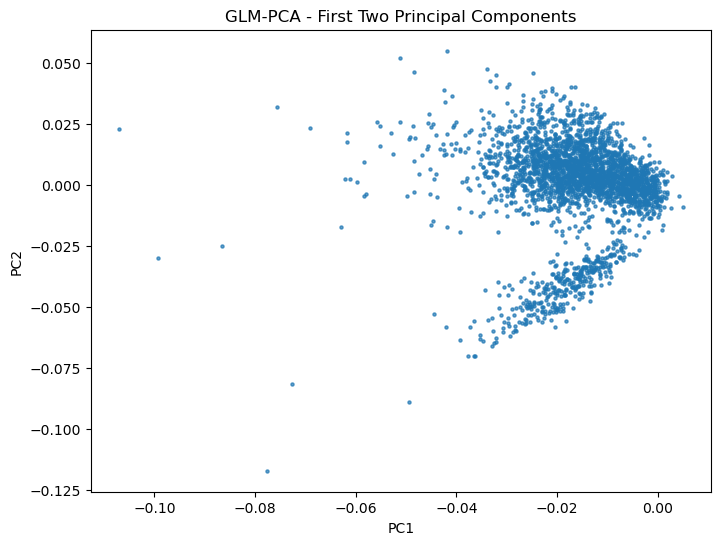

In [13]:
# Extract the first two principal components
pc1 = glmpca_loadings['dim1']
pc2 = glmpca_loadings['dim2']

# Create a scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pc1, pc2, s=5, alpha=0.7)
plt.title('GLM-PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
